# Vegetable Image Classifier

# Imports

In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.inception_v3 import InceptionV3


# Functions

In [47]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_and_preprocess_image(image_path, target_size=(250, 250)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img = img.convert('RGB')

            img_array = np.array(img) / 255.0
            img_array = img_array.astype(np.float32)
        return img_array
    except IOError as e:

        print(f"Error loading image {image_path}: {e}")
        return None

def grab_images(directory):
    X = []
    y = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img = load_and_preprocess_image(file_path)
                if img is not None:
                    X.append(img)
                    label = root.split(os.sep)[-1]
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

def create_model(n_classes):
  model = Sequential([
  Conv2D(32, (3,3), activation="relu", input_shape=(250,250,3)),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation="relu"),
  MaxPooling2D(2,2),
  Conv2D(128, (3,3), activation="relu"),
  MaxPooling2D(2,2),
  Conv2D(256, (3,3), activation="relu"),
  MaxPooling2D(2,2),
  Flatten(),
  Dense(64, activation="relu"),
  Dropout(0.5),
  Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
    )
  
  model.summary()
  return model


def plot_learning_curves(history):
    acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
    loss, val_loss = history.history["loss"], history.history["val_loss"]
    epochs = range(1,len(acc)+1)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, "bo-" ,label="Accuracy")
    plt.plot(epochs, val_acc, "gs-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "bo-" ,label="Training Loss")
    plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def create_confusion_matrix(y_pred, y_test):

    encoder = LabelEncoder()
    y_test_encoded = encoder.fit_transform(y_test)
    labels = encoder.classes_
    
    plt.figure(figsize=(15,7))
    cm = confusion_matrix(y_test_encoded, y_pred, labels= range(len(labels)))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel('True Labels')
    plt.title("Confusion Matrix")
    plt.show()

# Main Paths

In [3]:
PATH = "/Users/maukanmir/Downloads/Images/"
train_path, test_path, val_path = PATH + "train/", PATH + "test/", PATH + "validation/"

# Read in training data

In [24]:
X_train, y_train = grab_images(train_path)
X_test, y_test = grab_images(test_path)
X_val, y_val = grab_images(val_path)

# EDA Analysis

# Check Class Imbalance

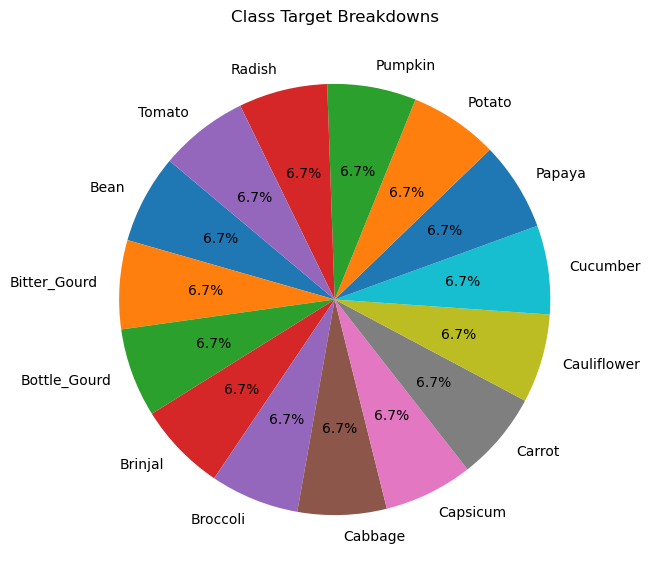

In [5]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 7))
plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
plt.title("Class Target Breakdowns")
plt.show()

# We have a balanced dataset

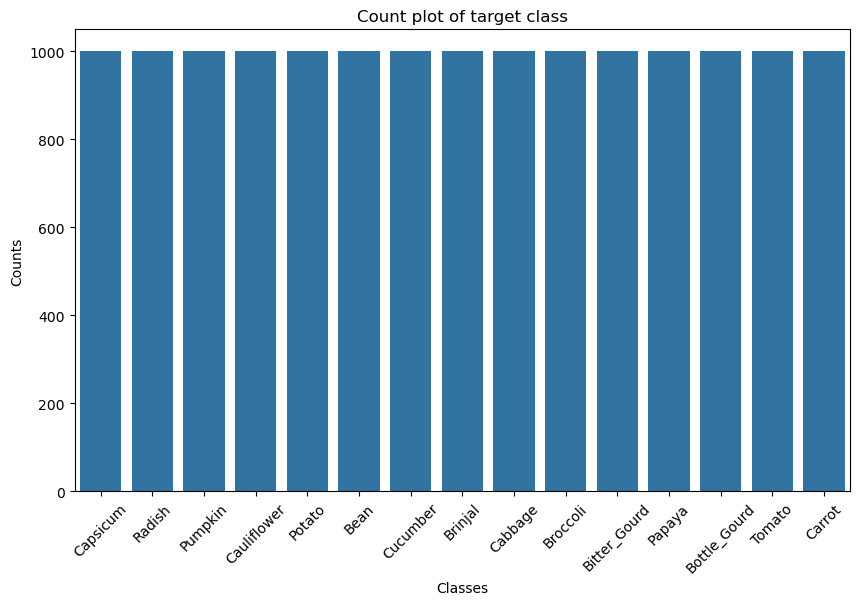

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Count plot of target class")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

# Data Augmentation

In [7]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(250, 250),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(250, 250),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(250, 250),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# Create Model

In [8]:
model = create_model(len(unique))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [9]:
train_steps_per_epoch = np.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

In [22]:
history = model.fit(
  train_generator,
  steps_per_epoch=train_steps_per_epoch,
  epochs=5,
  validation_data=validation_generator,
  validation_steps= validation_steps,
  callbacks=[early_stopping],
  verbose=0
)

# Evaluate Test Scores

In [23]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy", test_acc)

94/94 [==============================] - 8s 84ms/step - loss: 0.2675 - accuracy: 0.9210
Test Accuracy 0.9210000038146973


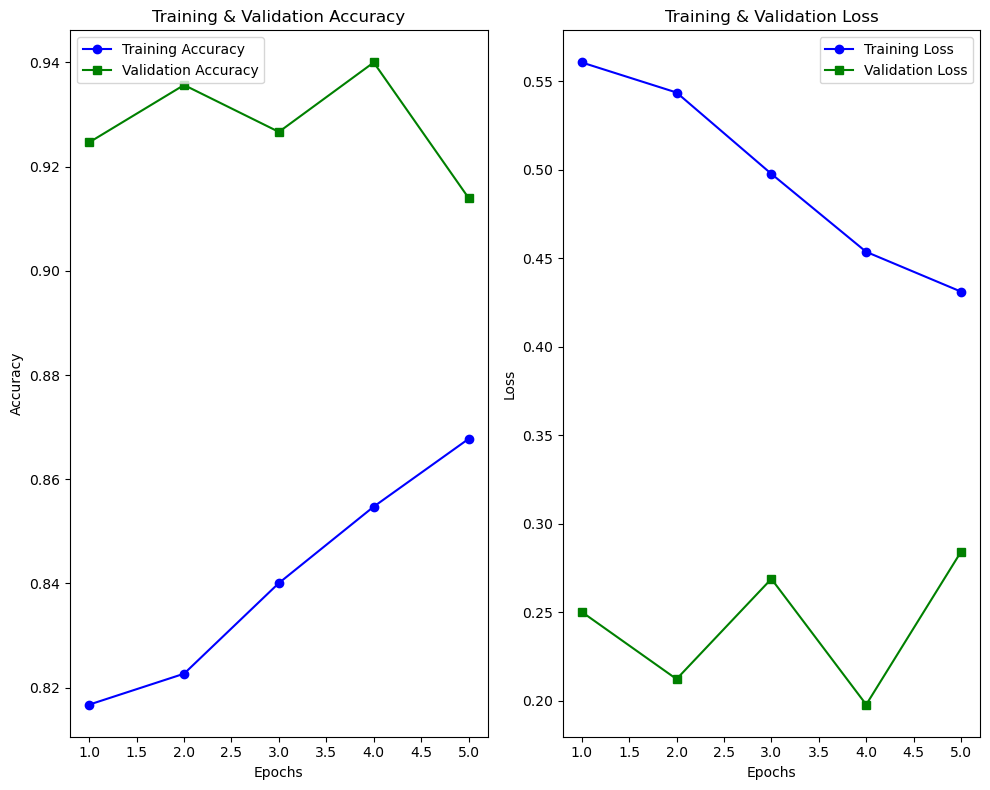

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

val_loss = history.history["val_loss"]
loss = history.history["loss"]

epochs = range(1, len(acc)+1)
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, "bo-", label="Training Accuracy")
plt.plot(epochs, val_acc, "gs-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



# Predictions

In [26]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

94/94 [==============================] - 8s 83ms/step


In [27]:
print("Unique labels in y_test:", np.unique(y_test))
print("Unique predictions in y_pred:", np.unique(y_pred))

Unique labels in y_test: ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']
Unique predictions in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


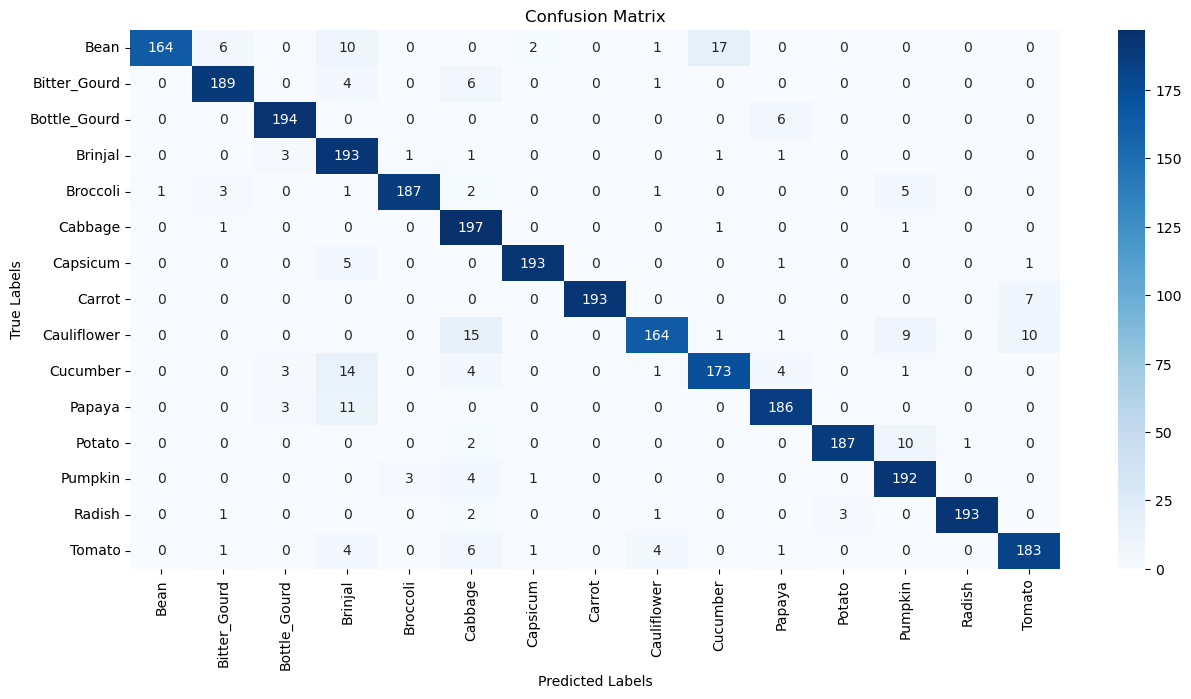

In [33]:
encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test)
labels = encoder.classes_

plt.figure(figsize=(15,7))
cm = confusion_matrix(y_test_encoded, y_pred, labels = range(len(labels)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report

In [34]:
report = classification_report(y_test_encoded, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       200
           1       0.94      0.94      0.94       200
           2       0.96      0.97      0.96       200
           3       0.80      0.96      0.87       200
           4       0.98      0.94      0.96       200
           5       0.82      0.98      0.90       200
           6       0.98      0.96      0.97       200
           7       1.00      0.96      0.98       200
           8       0.95      0.82      0.88       200
           9       0.90      0.86      0.88       200
          10       0.93      0.93      0.93       200
          11       0.98      0.94      0.96       200
          12       0.88      0.96      0.92       200
          13       0.99      0.96      0.98       200
          14       0.91      0.92      0.91       200

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93   

# Let's have fun with transfer learning

In [50]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
  layer.trainable = False


X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(128, activation="relu")(X)
X= Dropout(0.2)(X)
prediction = Dense(15, activation="softmax")(X)


model_v3 = Model(inputs=base_model.input, outputs=prediction)
early_stopping = EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True)

model_v3.compile(
  loss="sparse_categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)


history = model_v3.fit(
  train_generator,
  steps_per_epoch=train_steps_per_epoch,
  epochs=5,
  validation_data=validation_generator,
  validation_steps= validation_steps,
  callbacks=[early_stopping],
  verbose=0
)

In [51]:
test_loss, test_acc = model_v3.evaluate(test_generator)
print("Test Accuracy", test_acc)

94/94 [==============================] - 33s 355ms/step - loss: 0.0267 - accuracy: 0.9937
Test Accuracy 0.9936666488647461


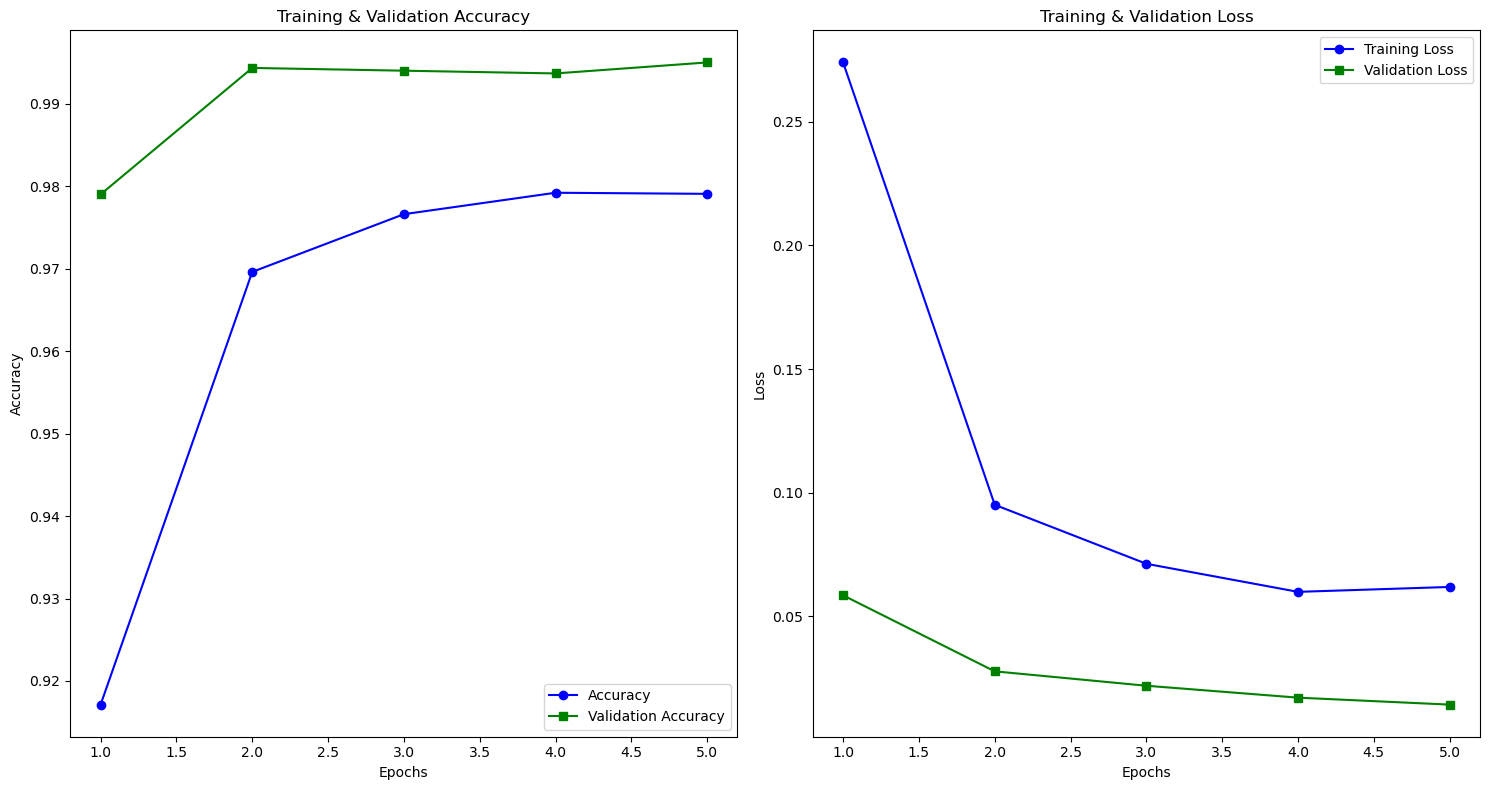

In [52]:
plot_learning_curves(history)

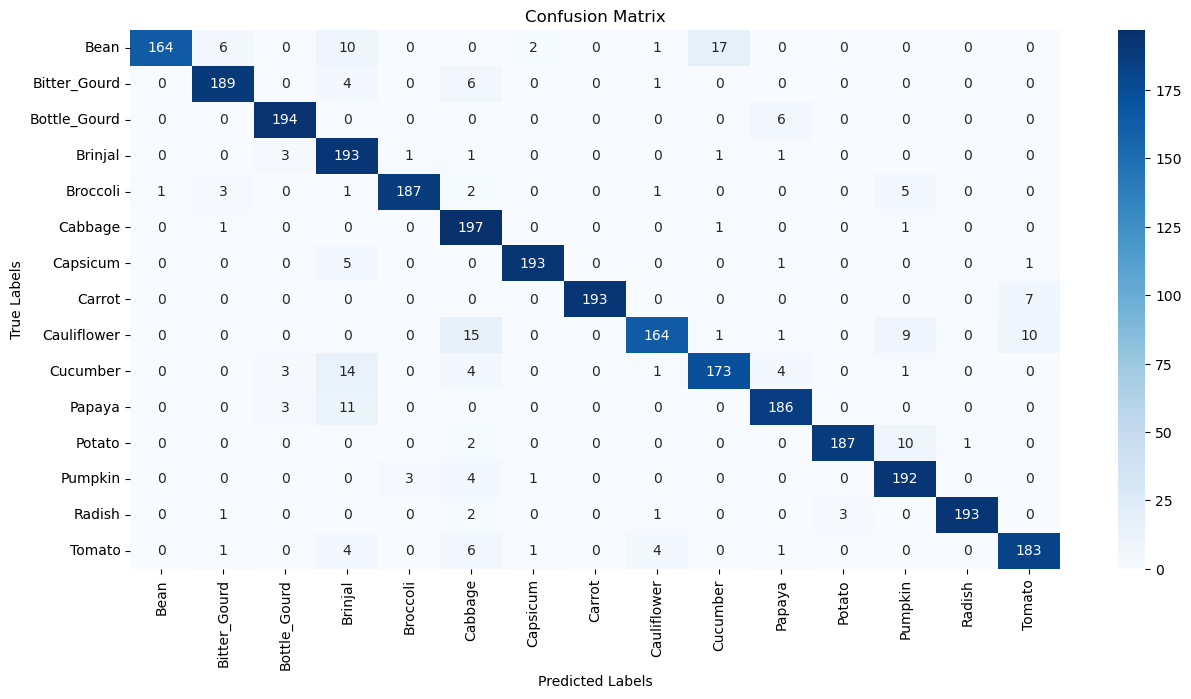

In [53]:
create_confusion_matrix(y_pred, y_test)

# Conclusion: Transfer learning offered a massive improvement with little overhead, overall we tested two different models with 90% + accuracy.